In [1]:
#%matplotlib notebook
import sys
import os
#messi
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

import s2p
import pickle
import rpc_model
import rpc_utils

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Set experiment

In [2]:
#GLOBAL VARIABLES
ALL_PIPELINE = True
CHECK_TRIANGULATION_DISTANCE = True
SAVE_SIFT_CLOUDS = True
print('Global variables defined')

# select site and order of input pairs
site = 'JAX_161' # IARPA, JAX_113, JAX_161, JAX_251
order = 'heuristic' # oracle, heuristic, sift

exp_name = site+'_ba_rotations_'+order
input_dir = os.path.join('exp/',exp_name)
print('All files will be saved in "'+ input_dir + '"')
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)

Global variables defined
All files will be saved in "exp/JAX_161_ba_rotations_heuristic"


### Load data (IARPA Multi-View Stereo 3D Mapping Challenge)

In [3]:
if site == 'IARPA':   
    # list the tiff images available in the remote folder
    IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
    myimages = utils.listFD(IARPAurl, 'TIF')

    # sort the images by acquisition date
    myimages = sorted(myimages, key=utils.acquisition_date)
    myimages.pop(11)
    myimages.pop(13)
    myimages.pop(19)
    print('Found {} images'.format(len(myimages)))

    # select the number of cameras for the current run
    n_cam = len(myimages)
    print('Number of images to be used:', n_cam)

    # load RPC coefficients
    myrpcs = [rpc_utils.rpc_from_geotiff(x) for x in myimages]
    print('Finished loading RPC coefficients')
    
    # set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
    aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                         [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

### Load data (IEEE GRSS Data Fusion Contest)

In [4]:
import bs4
import requests

def is_absolute(url):
    return bool(requests.utils.urlparse(url).netloc)

def find(url, extension):
    """
    Recursive directory listing, like "find . -name "*extension".

    Args:
        url (str):  directory url
        extension (str): file extension to match

    Returns:
        list of urls to files
    """
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    files = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith(extension)]
    folders = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith('/')]

    files_urls = [f if is_absolute(f) else os.path.join(url, os.path.basename(f)) for f in files]
    folders_urls = [f if is_absolute(f) else os.path.join(url, os.path.basename(f.rstrip('/'))) for f in folders]

    for u in folders_urls:
        if not u.endswith(('../', '..')):
            files_urls += find(u, extension)
    return files_urls

if site in ['JAX_113', 'JAX_161', 'JAX_251']:   
    # list the tiff images available in the remote folder
    myimages = find('http://138.231.80.166:2332/core3d/Jacksonville/WV3/PAN/', '.NTF.tif')

    # list the tiff images available in the remote folder
    mygts = find('http://138.231.80.166:2332/grss-2019/track_3/Track3-Truth-geolocated/', '_DSM.tif')
    mygt_fn = [i for i in mygts if site in i]
    aoi = utils.get_image_longlat_polygon(mygt_fn[0])
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

    # select the number of cameras for the current run
    n_cam = len(myimages)
    print('Number of images to be used:', n_cam)

    # load RPC coefficients
    myrpcs = [rpc_utils.rpc_from_geotiff(x) for x in myimages]
    print('Finished loading RPC coefficients')

Number of images to be used: 26
Finished loading RPC coefficients


### Save image crops

Finished cropping the AOI in each image



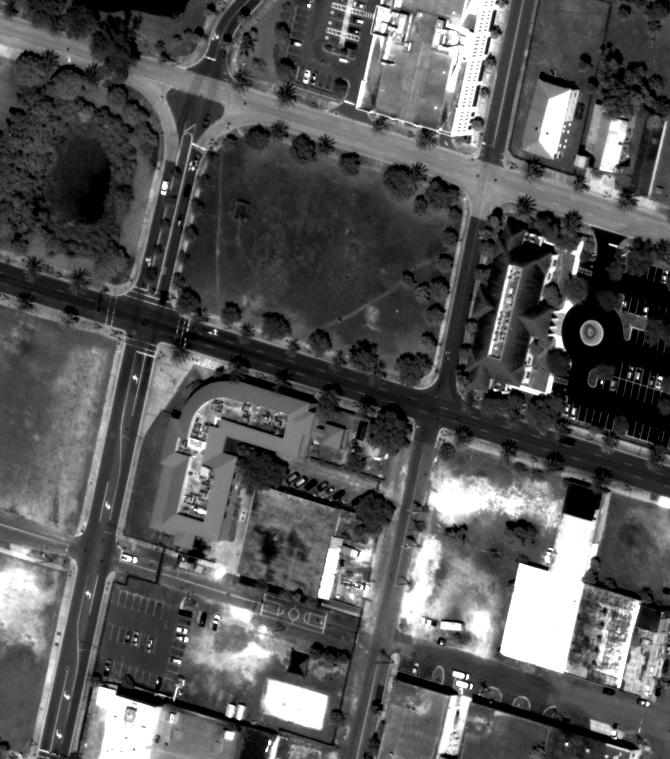
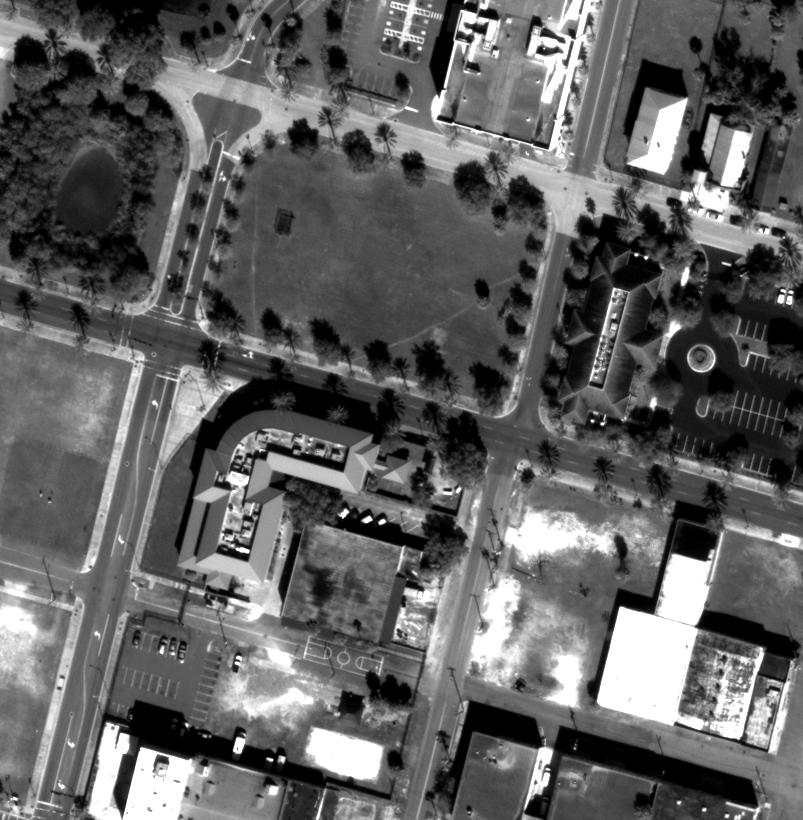
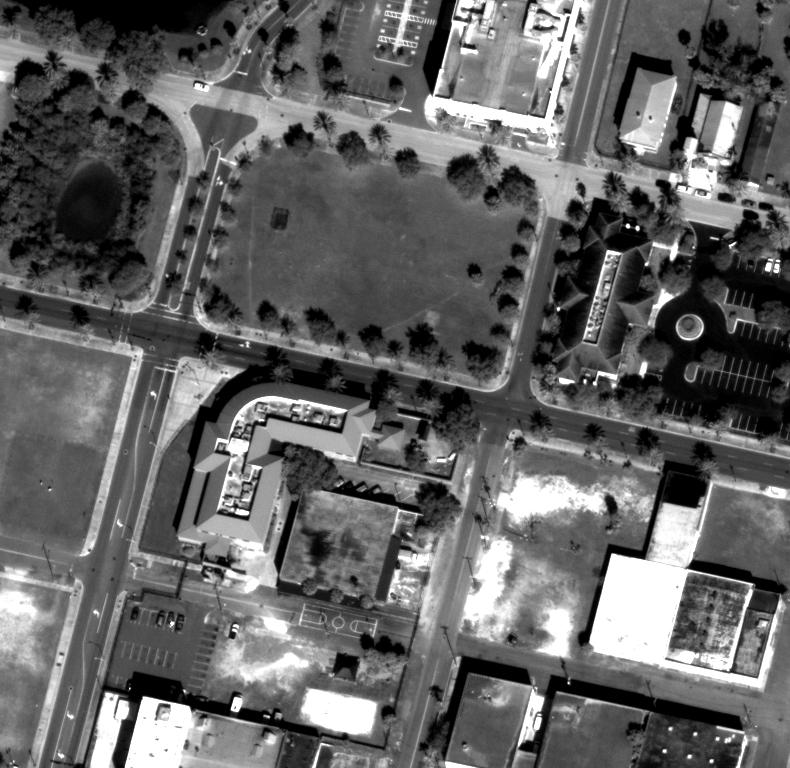
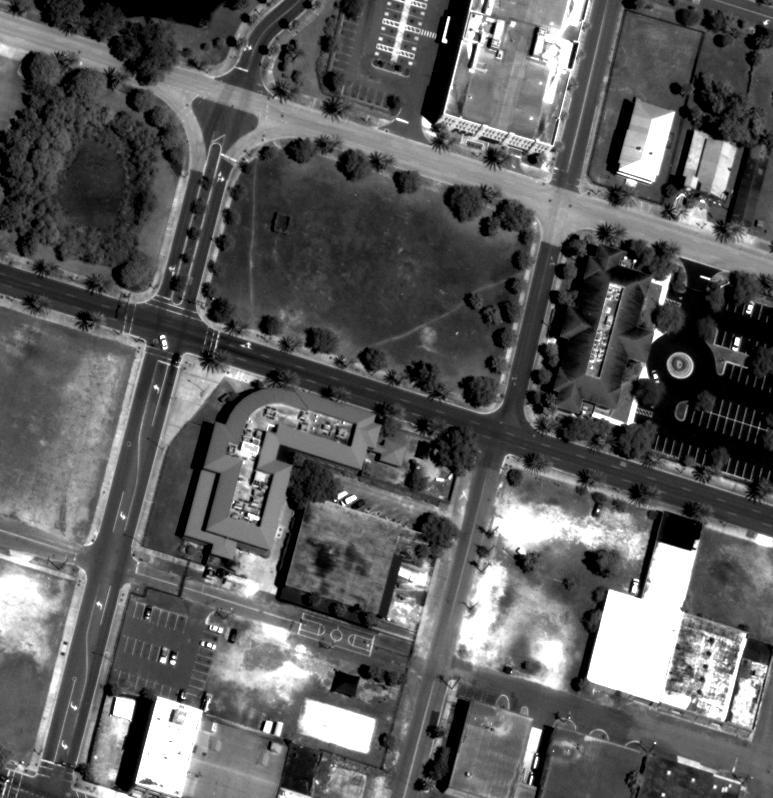
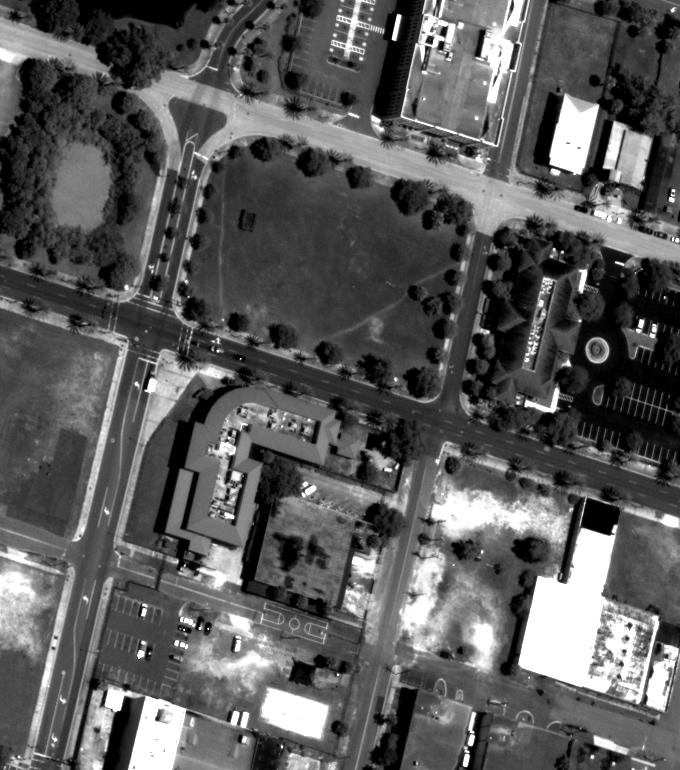
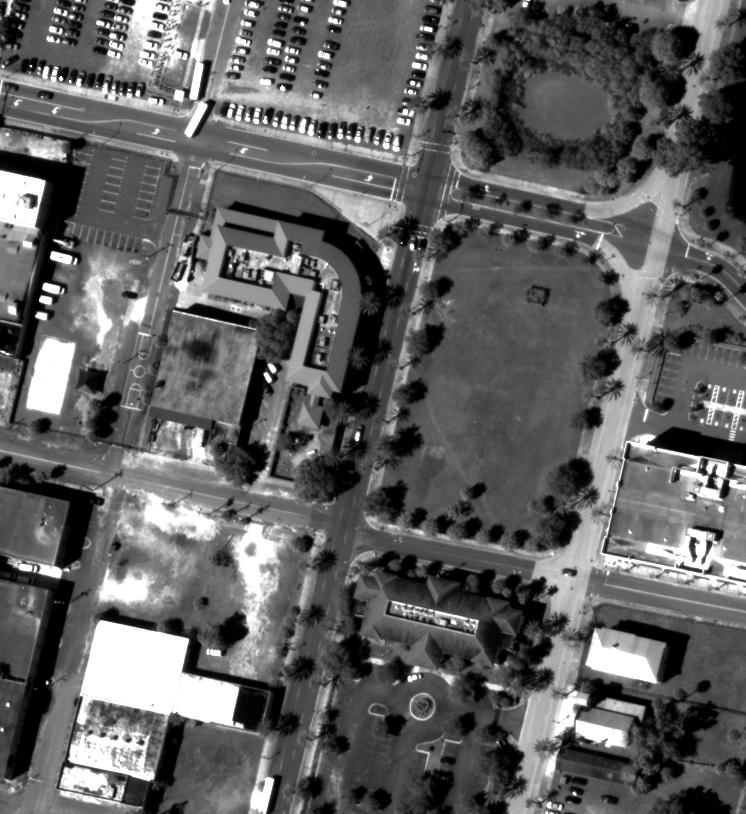
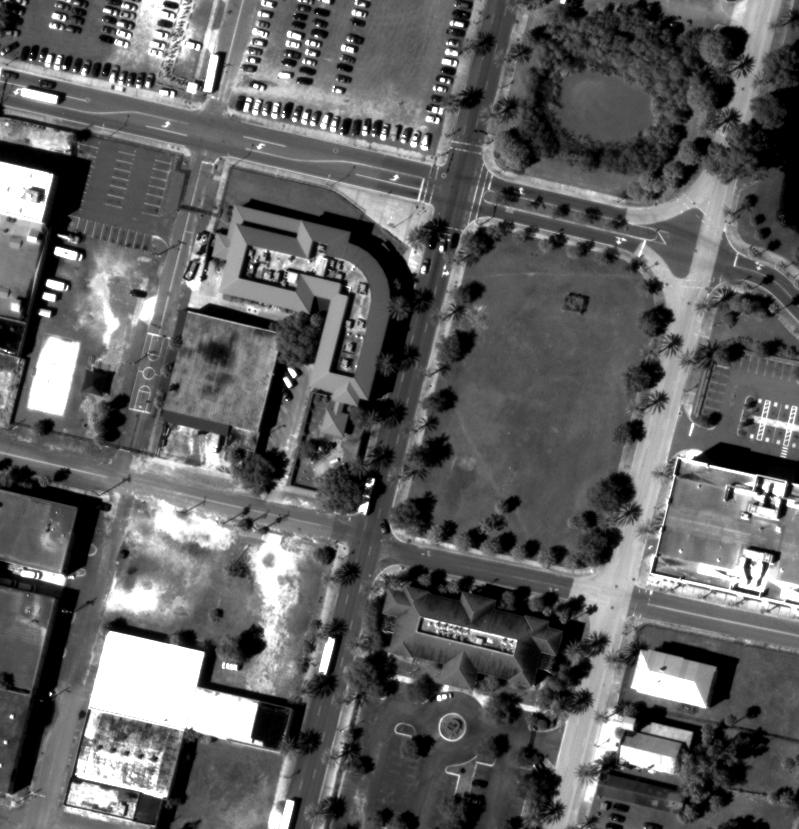
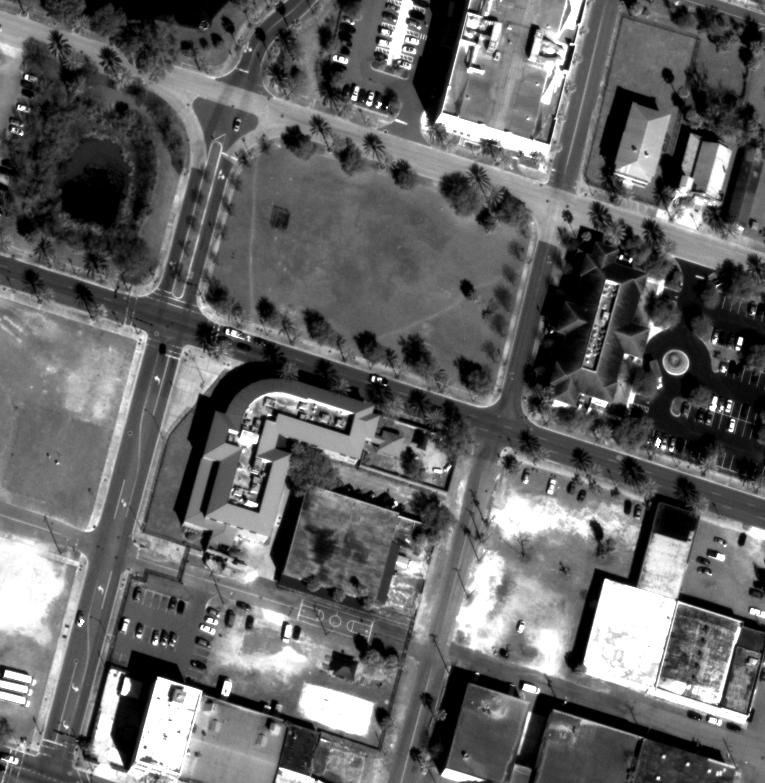
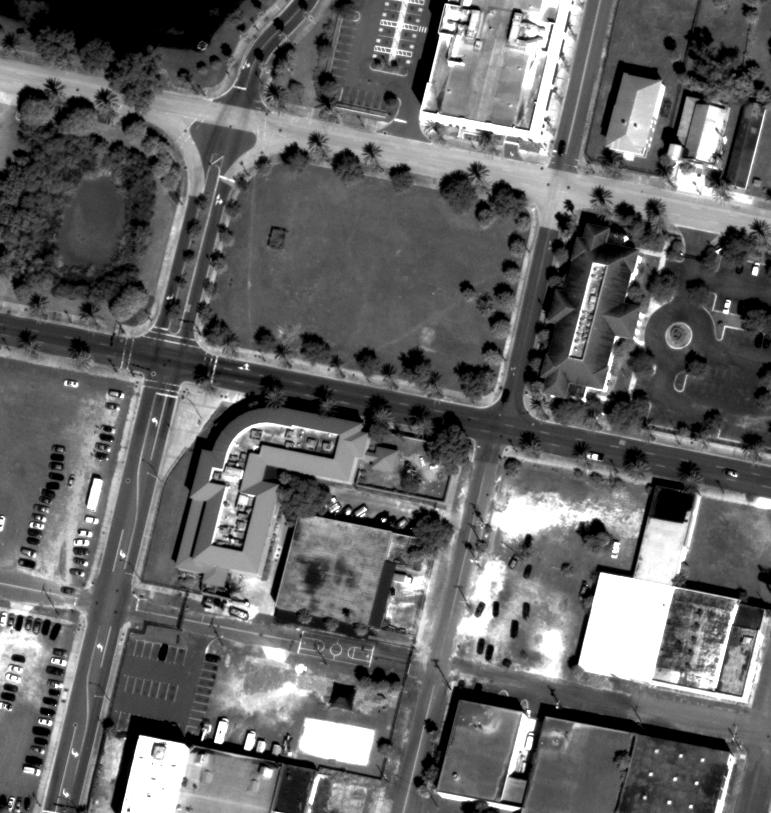
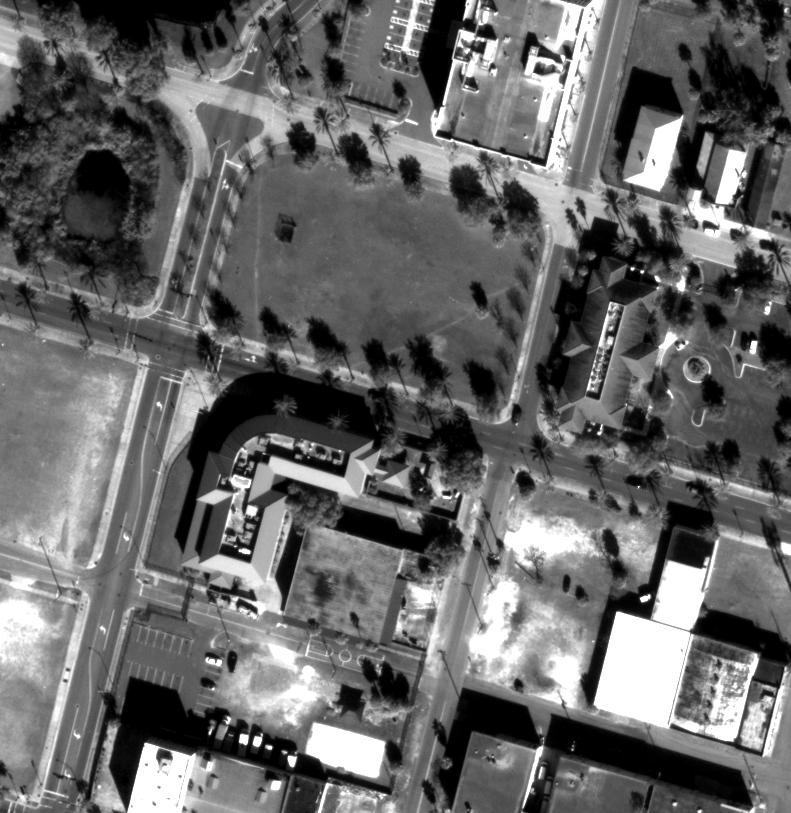
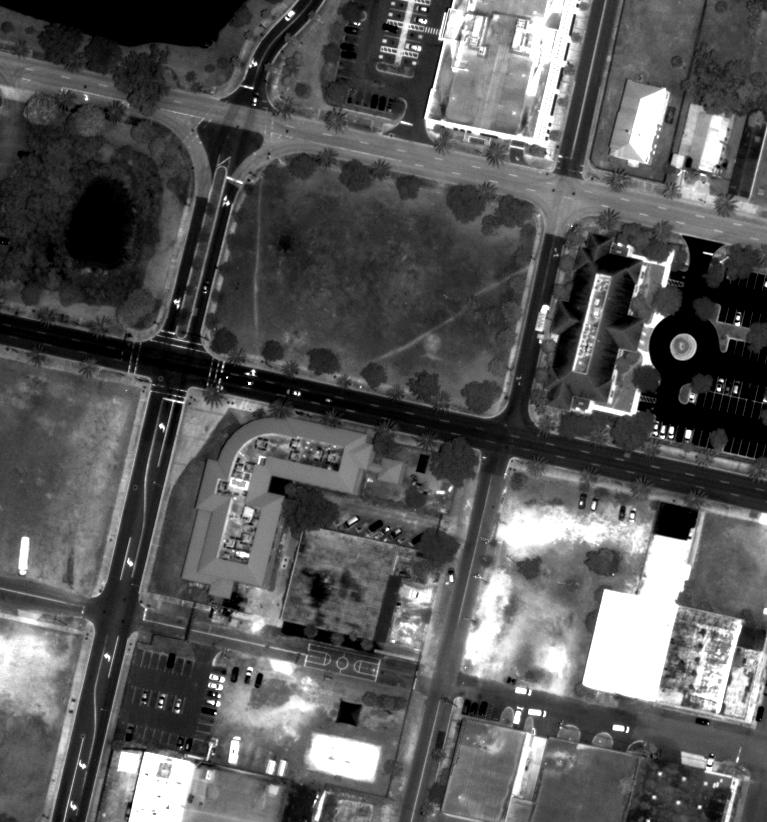
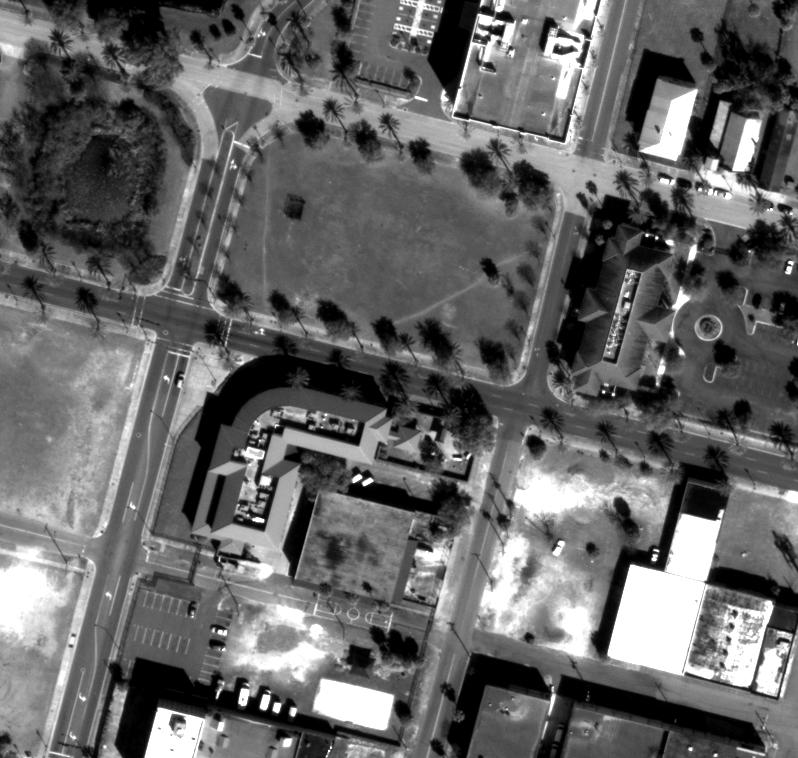
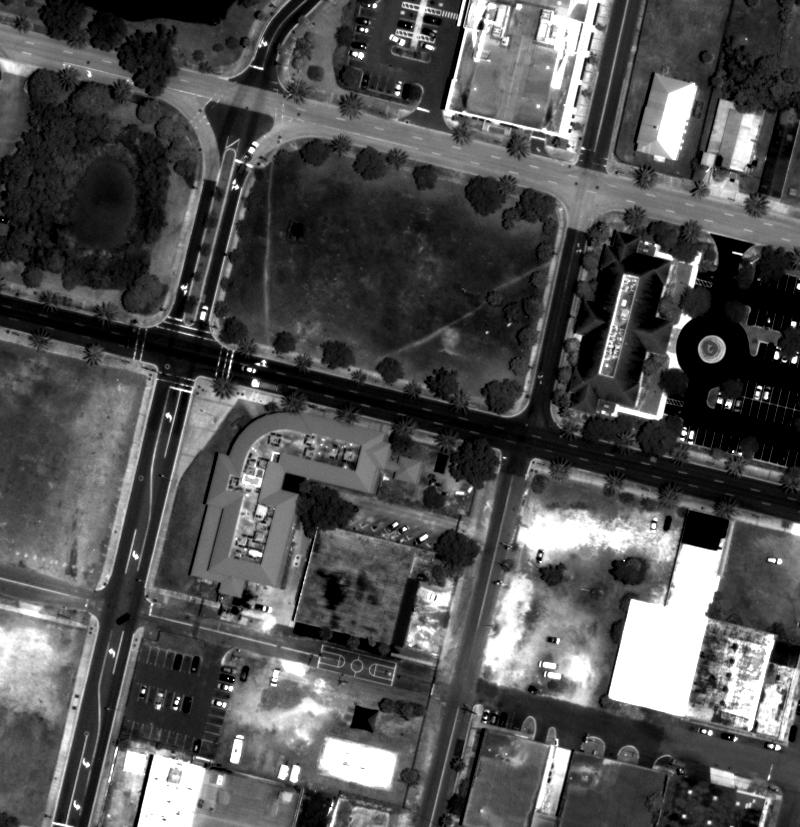
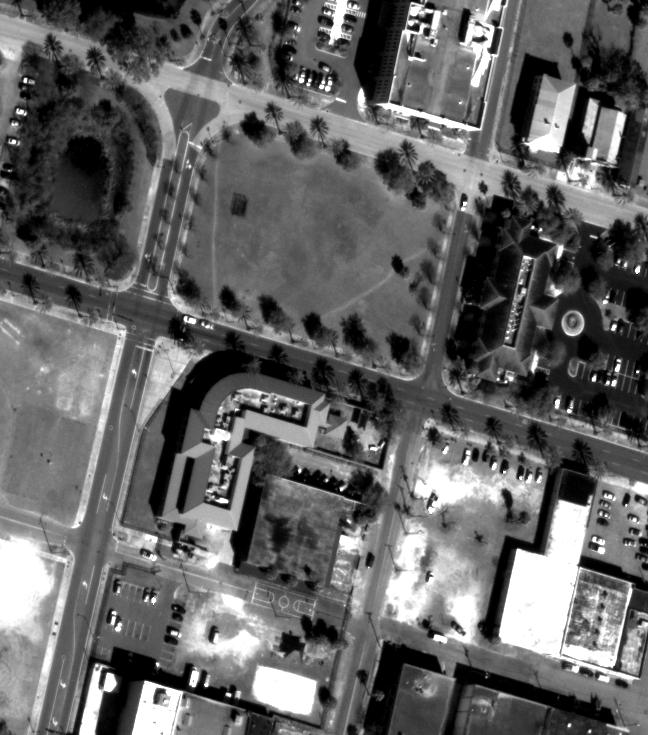
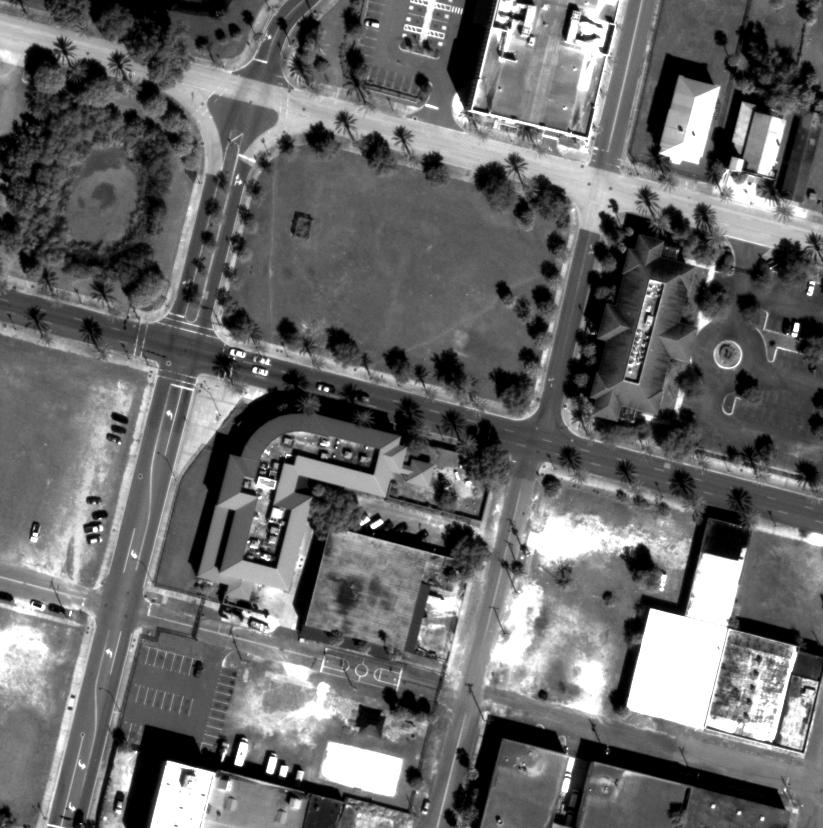
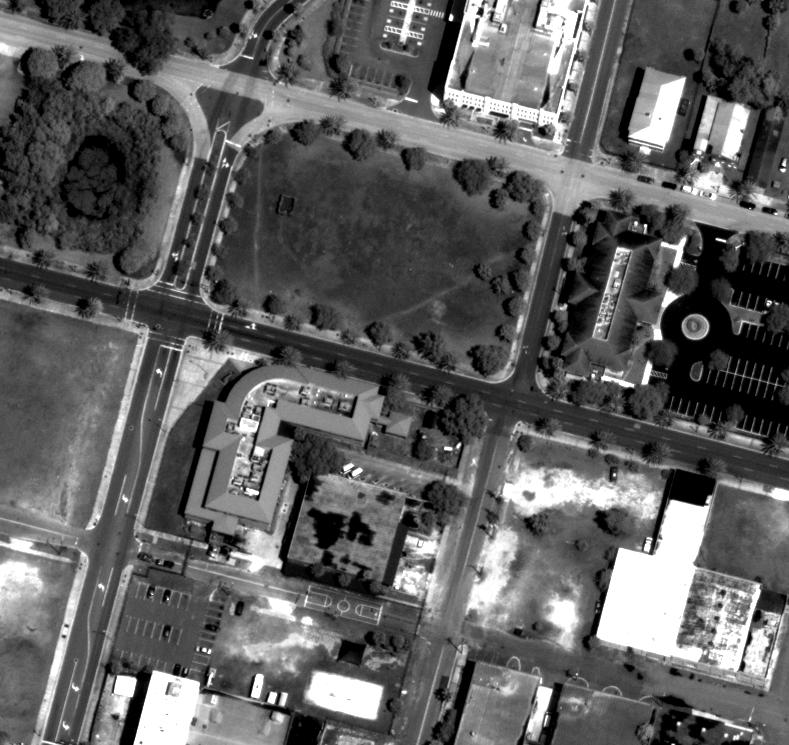
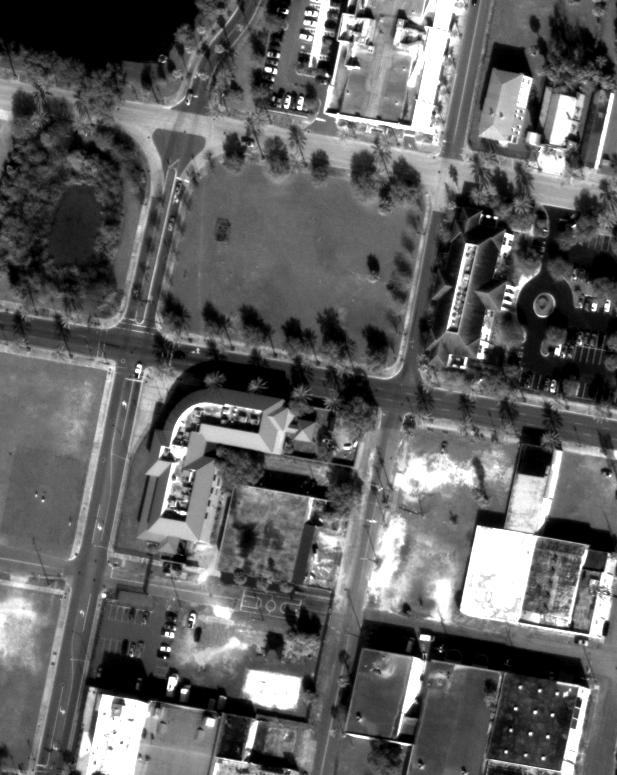
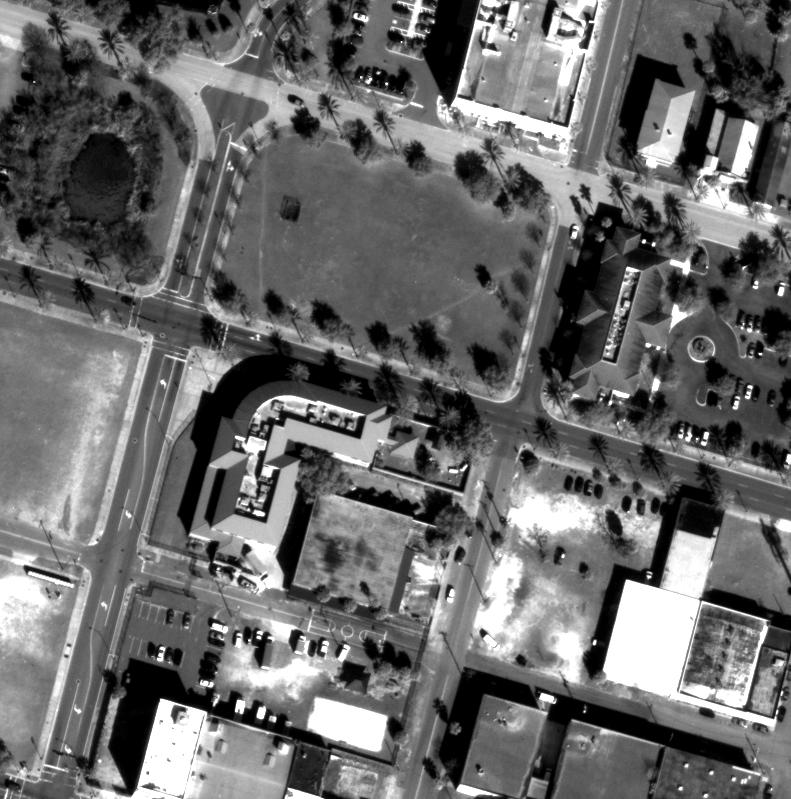
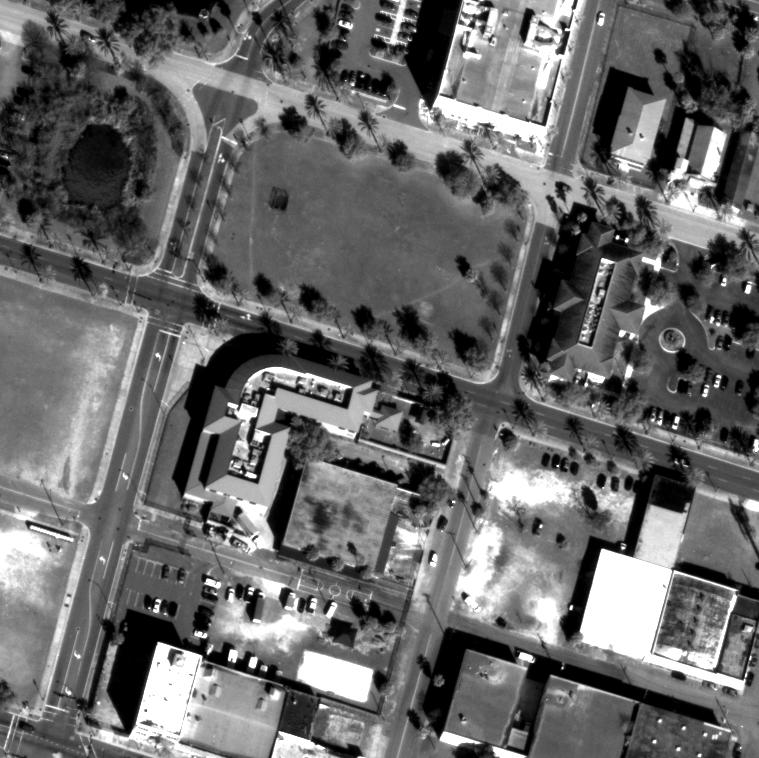
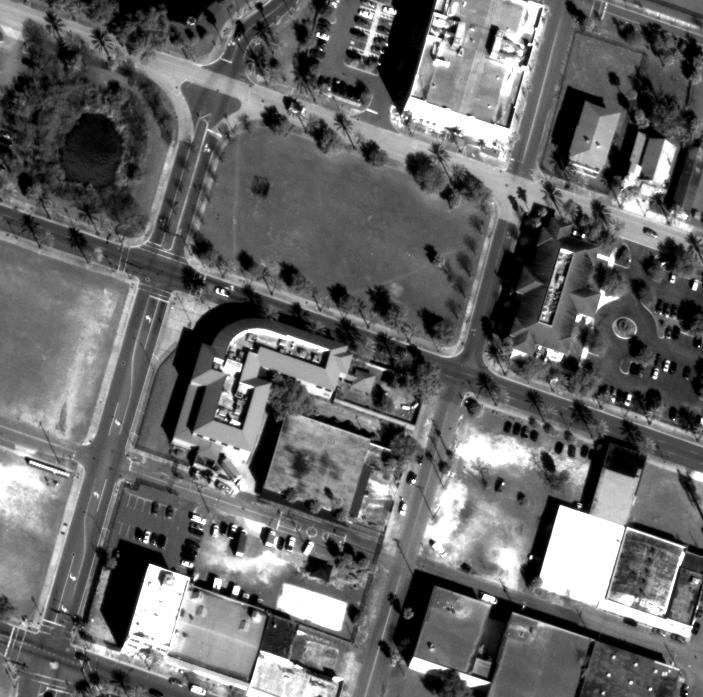
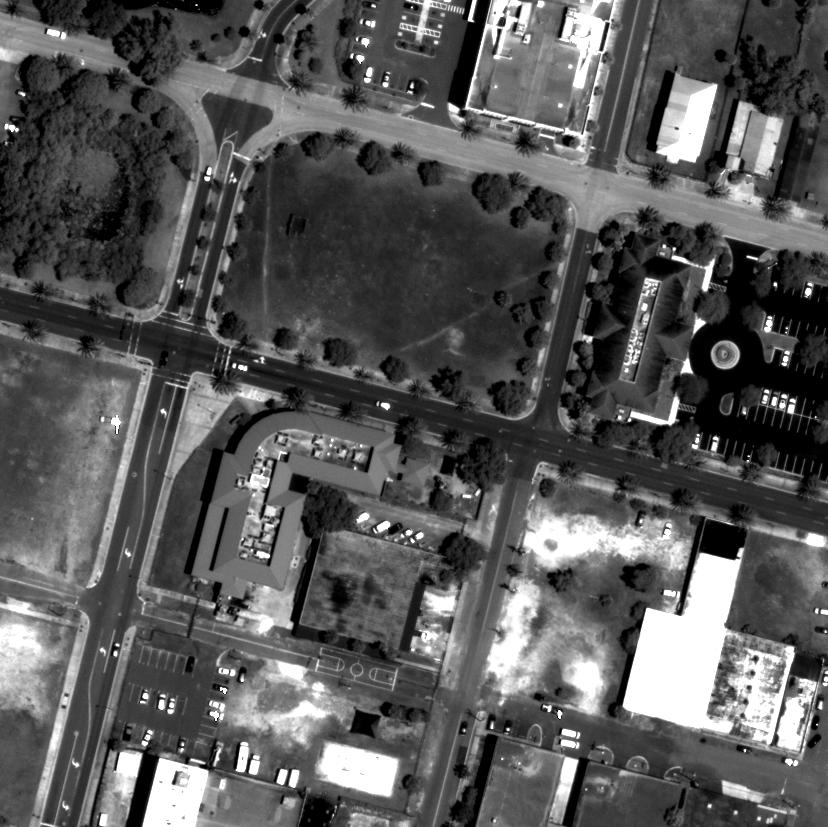
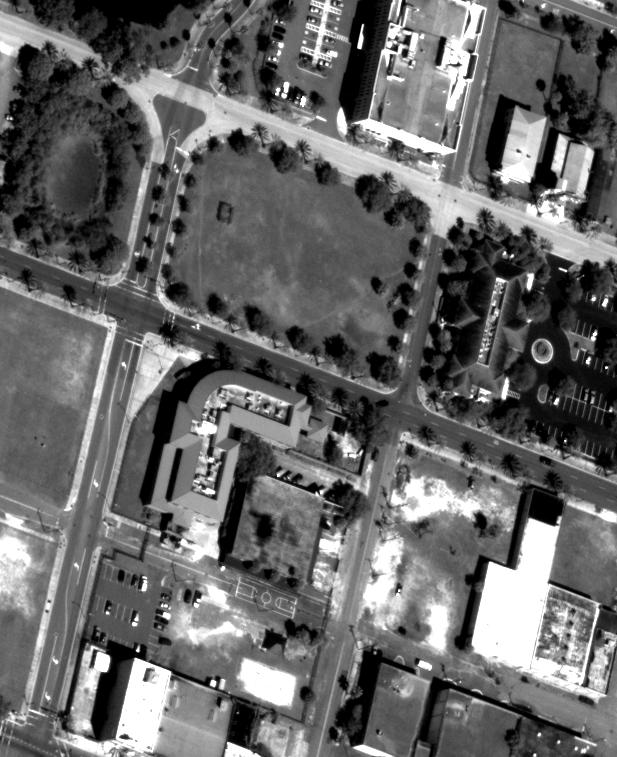
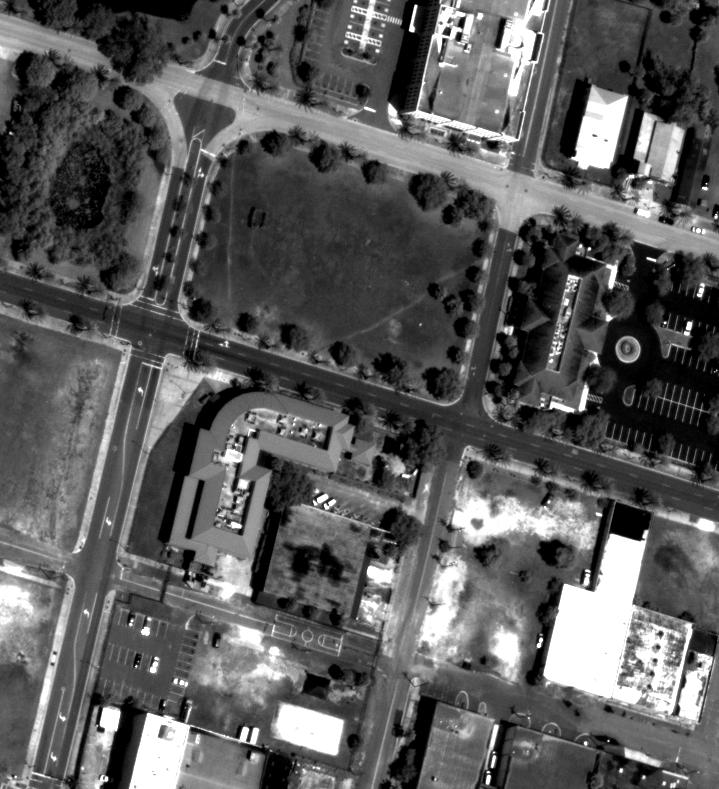
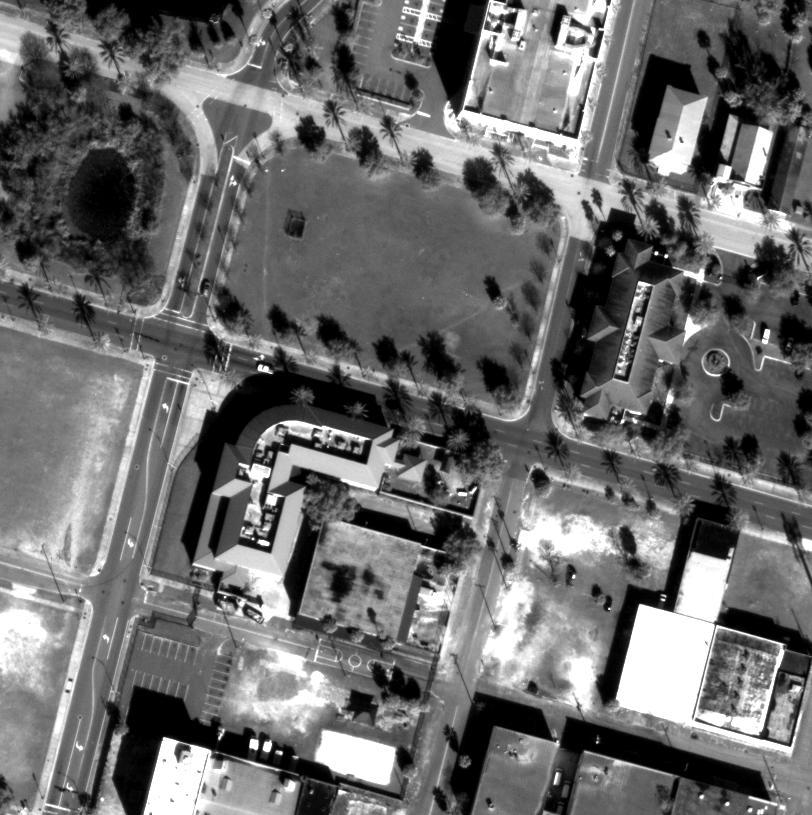
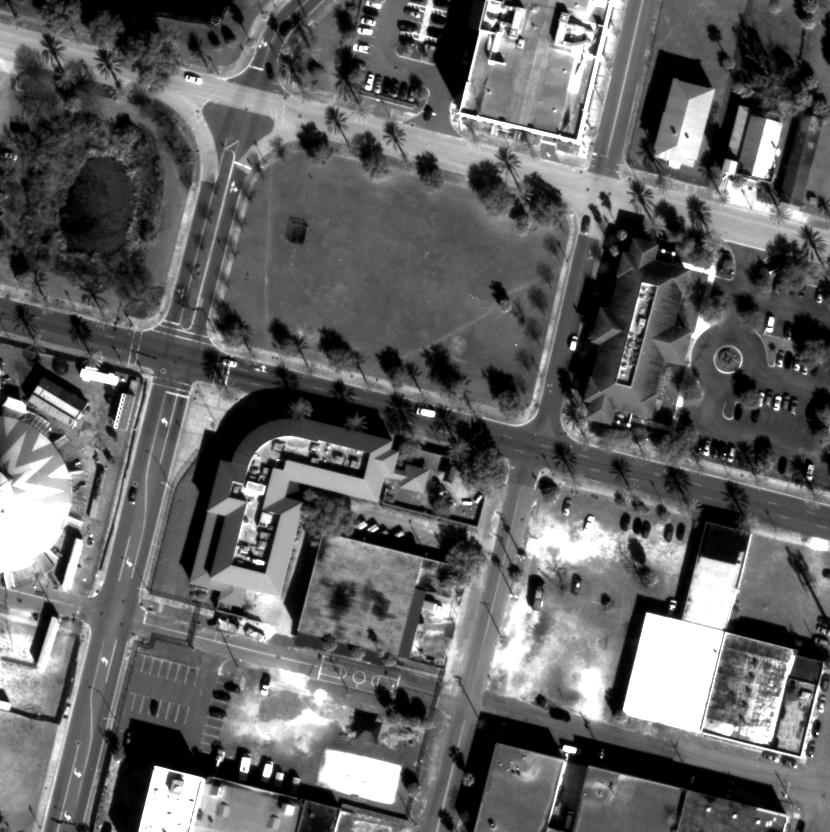
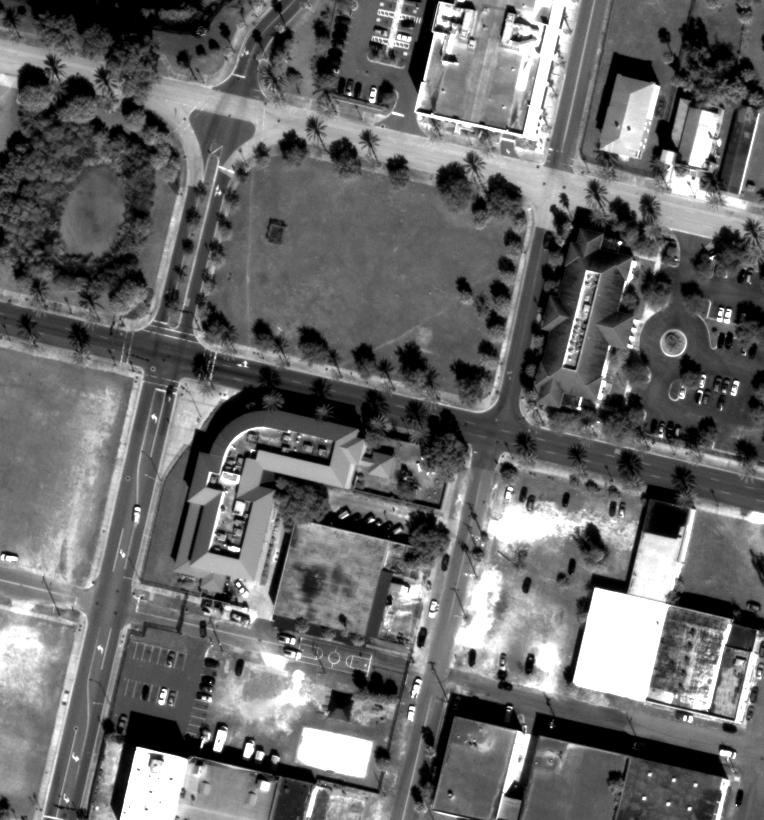

In [5]:
# get the altitude of the center of the AOI
lon, lat = aoi['center']
z = srtm4.srtm4(lon, lat)

# crop the selected AOI in each image
mycrops, im = [], []
for iter_cont, f in enumerate(range(len(myimages))):
    crop, x0, y0 = utils.crop_aoi(myimages[f], aoi, z)
    mycrops.append({ 'crop': utils.simple_equalization_8bit(crop), 'x0': x0, 'y0': y0 })
    im.append(utils.simple_equalization_8bit(crop))
    print('\r{} / {} done'.format(iter_cont+1, len(myimages)), end = '\r')
print('Finished cropping the AOI in each image')
vistools.display_gallery(im)

save_crops = False
if save_crops:
    crops_path = input_dir+'/crops'
    if not os.path.isdir(crops_path):
        os.mkdir(crops_path)
    import cv2
    for image, cont in zip(im, range(n_cam)):
        cv2.imwrite(crops_path+'/{:02}.png'.format(cont), image)

### Approximate RPCs as projection matrices

In [6]:
# set the camera model to be used: Affine, anything else will be treated as Perspective
cam_model = 'Perspective'

P_crop = []
if cam_model == 'Affine':
    p_geodetic = [aoi['center'][0], aoi['center'][1], 31.0] # lon, lat, alt
    p_x, p_y, p_z = ba_utils.latlon_to_ecef_custom(p_geodetic[1], p_geodetic[0], p_geodetic[2]) # in meters
    p_geocentric = [p_x, p_y, p_z]
    for rpc, crop in zip(myrpcs, mycrops):
        # approximate current rpc as an affine 3x4 matrix
        P_img = rectification.rpc_affine_approximation2(rpc, p_geocentric)
        x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi, rpc.alt_offset)
        #express P in terms of crop coord by applying the translation x0, y0 (i.e. top-left corner of the crop)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        P_crop.append(current_P/current_P[2,3])
    print('RPCs successfully approximated as affine cameras')
else:
    for rpc, crop in zip(myrpcs, mycrops):
        # approximate current rpc as a perspective 3x4 matrix
        x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
        P_img = rpc_utils.approx_rpc_as_proj_matrix(rpc, [x,x+w,10], [y,y+h,10], \
                                                    [rpc.alt_offset - 100, rpc.alt_offset + 100, 10])
        #express P in terms of crop coord by applying the translation x0, y0 (i.e. top-left corner of the crop)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        P_crop.append(current_P/current_P[2,3])     
    print('RPCs successfully approximated as perspective cameras')

RPCs successfully approximated as perspective cameras


### Generate feature tracks

In [7]:
#generate input feature tracks into a correspondence matrix C with shape (2*M)xN (i.e. M cameras, N tracks)

# IMPORTANT: pip3 install opencv-contrib-python==3.4.0.12

import timeit
import cv2
from multiprocessing import Pool

input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]    
n_img = len(input_seq)

print('Running feature detection...\n')
start = timeit.default_timer()
last_stop = start

# (1) detect SIFT keypoints in all images
kp_cont = 0
features, all_keypoints, all_vertices = [], [], []
for idx in range(n_img):
    kp, des, pts = ba_utils.find_SIFT_kp(input_seq[idx])
    kp_id = np.arange(kp_cont, kp_cont + pts.shape[0]).tolist()
    features.append({ 'kp': pts, 'des': np.array(des), 'id': kp_id })
    all_keypoints.extend(pts.tolist())
    tmp = np.vstack((np.ones(pts.shape[0]).astype(int)*idx, kp_id)).T
    all_vertices.extend( tmp.tolist() )
    print('Found', pts.shape[0], 'keypoints in image', idx)
    kp_cont += pts.shape[0]
    #im_kp=cv2.drawKeypoints(input_seq[idx],kp,outImage=np.array([]))
    #vistools.display_image(im_kp) 

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop


print('\nComputing pairs to be matched...\n')

#(2) pairs to match
pairs_to_match, matching_args = [], []
for i in range(n_img):
    for j in range(i+1,n_img):
        pairs_to_match.append((i,j))
print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop


print('\nMatching...\n')

# (3) match
all_pairwise_matches = []
for idx, [i,j] in enumerate(pairs_to_match):
    kp_i, des_i, kp_i_id = features[i]['kp'], features[i]['des'], np.array(features[i]['id'])
    kp_j, des_j, kp_j_id = features[j]['kp'], features[j]['des'], np.array(features[j]['id'])
    indices_m_kp_i, indices_m_kp_j = ba_utils.match_pair(kp_i, kp_j, des_i, des_j)

    n_matches = 0 if indices_m_kp_i is None else len(indices_m_kp_i)
    print('Pair ({},{}) -> {} matches'.format(i,j,n_matches))

    # display matches for pair (i,j)
    #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
    #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

    if indices_m_kp_i is not None:
        matches_i_j = np.vstack((kp_i_id[indices_m_kp_i], kp_j_id[indices_m_kp_j])).T
        all_pairwise_matches.extend(matches_i_j.tolist())
    

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nRunning union-find...')

def find(parents, feature_id):
    p = parents[feature_id]
    return feature_id if not p else find(parents, p)

def union(parents, feature_i_idx, feature_j_idx):
    p_1, p_2 = find(parents, feature_i_idx), find(parents, feature_j_idx)
    if p_1 != p_2: 
        parents[p_1] = p_2

parents = [None]*(len(all_vertices))
for feature_i_idx, feature_j_idx in all_pairwise_matches:
    #fi, fj = vertex_i_idx, vertex_j_idx
    union(parents, feature_i_idx, feature_j_idx)

# parents without None
parents = [find(parents, feature_id) for feature_id, v in enumerate(parents)]

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nBuilding correspondence matrix C...\n')

# parents = track_id
_, parents_indices, parents_counts = np.unique(parents, return_inverse=True, return_counts=True)
n_tracks = np.sum(1*(parents_counts>1))
track_parents = np.array(parents)[parents_counts[parents_indices] > 1]
_, track_idx_from_parent, _ = np.unique(track_parents, return_inverse=True, return_counts=True)

# t_idx, parent_id
track_indices = np.zeros(len(parents))
track_indices[:] = np.nan
track_indices[parents_counts[parents_indices] > 1] = track_idx_from_parent

C = np.zeros((2*n_cam, n_tracks))
C[:] = np.nan
for (feature_i_id, feature_j_id) in all_pairwise_matches:
    t_idx, t_idx2 = int(track_indices[feature_i_id]), int(track_indices[feature_j_id])
    im_id_i, im_id_j = all_vertices[feature_i_id][0], all_vertices[feature_j_id][0]
    C[(2*im_id_i):(2*im_id_i+2), t_idx] = np.array(all_keypoints[feature_i_id])
    C[(2*im_id_j):(2*im_id_j+2), t_idx] = np.array(all_keypoints[feature_j_id])

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

hours, rem = divmod(last_stop - start, 3600)
minutes, seconds = divmod(rem, 60)
print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))

pickle_out = open(input_dir+'/Cmatrix.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')

Running feature detection...

Found 5321 keypoints in image 0
Found 6468 keypoints in image 1
Found 6420 keypoints in image 2
Found 6434 keypoints in image 3
Found 5348 keypoints in image 4
Found 6346 keypoints in image 5
Found 6925 keypoints in image 6
Found 6134 keypoints in image 7
Found 6781 keypoints in image 8
Found 6271 keypoints in image 9
Found 5210 keypoints in image 10
Found 5534 keypoints in image 11
Found 6010 keypoints in image 12
Found 4713 keypoints in image 13
Found 7073 keypoints in image 14
Found 6333 keypoints in image 15
Found 5081 keypoints in image 16
Found 6740 keypoints in image 17
Found 6400 keypoints in image 18
Found 5732 keypoints in image 19
Found 6721 keypoints in image 20
Found 5305 keypoints in image 21
Found 6094 keypoints in image 22
Found 6980 keypoints in image 23
Found 7094 keypoints in image 24
Found 6889 keypoints in image 25

...done in 3.4515463798306882 seconds

Computing pairs to be matched...

325 / 325 pairs to be matched

...done in 0.0005

Pair (15,16) -> 22 matches
Pair (15,17) -> 99 matches
Pair (15,18) -> 77 matches
Pair (15,19) -> 58 matches
Pair (15,20) -> 316 matches
Pair (15,21) -> 71 matches
Pair (15,22) -> 345 matches
Pair (15,23) -> 120 matches
Pair (15,24) -> 128 matches
Pair (15,25) -> 91 matches
Pair (16,17) -> 68 matches
Pair (16,18) -> 40 matches
Pair (16,19) -> 25 matches
Pair (16,20) -> 10 matches
Pair (16,21) -> 50 matches
Pair (16,22) -> 20 matches
Pair (16,23) -> 86 matches
Pair (16,24) -> 61 matches
Pair (16,25) -> 148 matches
Pair (17,18) -> 2584 matches
Pair (17,19) -> 1251 matches
Pair (17,20) -> 82 matches
Pair (17,21) -> 57 matches
Pair (17,22) -> 94 matches
Pair (17,23) -> 1224 matches
Pair (17,24) -> 954 matches
Pair (17,25) -> 211 matches
Pair (18,19) -> 2032 matches
Pair (18,20) -> 63 matches
Pair (18,21) -> 55 matches
Pair (18,22) -> 72 matches
Pair (18,23) -> 700 matches
Pair (18,24) -> 626 matches
Pair (18,25) -> 152 matches
Pair (19,20) -> 35 matches
Pair (19,21) -> 31 matches
Pair (19,2

Load feature tracks:

In [8]:
#pickle_in = open(input_dir+'/Cmatrix.pickle','rb')
#C = pickle.load(pickle_in)
#print('Correspondence matrix loaded!')

### Define Bundle Adjustment parameters

In [9]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

print('Defining BA input parameters...')
n_new, n_adj, pairs_to_triangulate = n_cam, 0, pairs_to_match
params_opt, cam_params, pts_3d, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, n_adj, n_new, pairs_to_triangulate)
print('...done!\n')

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}\n'.format(pts_3d.shape, cam_params.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

Defining BA input parameters...


26 cameras in total, 0 fixed and 26 to be adjusted
3 parameters per camera and 14176 3d points to be optimized
...done!

pts_2d.shape:(46609, 2)  pts_ind.shape:(46609,)  cam_ind.shape:(46609,)
pts_3d.shape:(14176, 3)  cam_params.shape:(26, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


In [10]:
ba_params['n_cam_fix']

0

### Run Bundle Adjustment (soft L1 loss)

Shape of matrix A: 93218x42606
`ftol` termination condition is satisfied.
Function evaluations 672, initial cost 3.1452e+05, final cost 1.1526e+04, first-order optimality 8.01e+06.
Optimization took 228 seconds


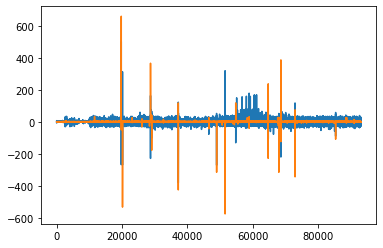

In [11]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters

f0 = ba_utils.fun(params_opt, cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, params_opt, jac_sparsity=A, verbose=1, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, cam_params, pts_3d)

### Check reprojection error before and after Bundle Adjustment

Error before BA (mean / median): 14.34 / 12.57
Error after  BA (mean / median): 0.81 / 0.39


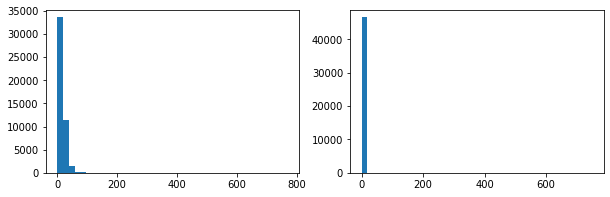

In [12]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2))
very_intial_error = init_e
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40);
f[1].hist(ba_e, bins=40); 

### Remove mismatches based on reprojection error

Elbow value is 1.5280566854357565


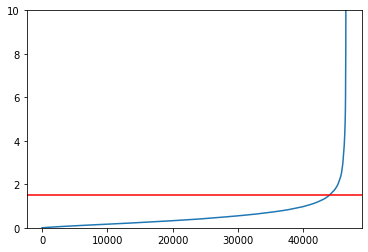

Deleted 1302 observations (2.79%) and 61 tracks (0.43%)

Correspondence matrix saved!


In [13]:
elbow_value = ba_utils.get_elbow_value(ba_e, 95)
print('Elbow value is {}'.format(elbow_value))
fig = plt.figure()
plt.plot(np.sort(ba_e))
plt.axhline(y=elbow_value, color='r', linestyle='-')
plt.ylim([0, 10])
plt.show()
newC = ba_utils.remove_outlier_obs(ba_e, pts_ind, cam_ind, C, pairs_to_triangulate, thr=max(elbow_value,2.0))

pickle_out = open(input_dir+'/Cmatrix2.pickle','wb')
pickle.dump(newC, pickle_out)
pickle_out.close()
print('Correspondence matrix saved!')

In [14]:
print('Defining BA input parameters...')
params_opt, cam_params, pts_3d, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, newC, cam_model, n_adj, n_new, pairs_to_triangulate)
print('...done!\n')

Defining BA input parameters...


Track 1267 / 14115 done

26 cameras in total, 0 fixed and 26 to be adjusted
3 parameters per camera and 14115 3d points to be optimized
...done!



In [15]:
pickle_out = open(input_dir+'/features2.pickle','wb')
pickle.dump(newC, pickle_out)
pickle_out.close()
print('Correspondence matrix saved!')

Correspondence matrix saved!


### Run Bundle Adjustment (L2 loss)

Shape of matrix A: 90534x42423
`ftol` termination condition is satisfied.
Function evaluations 3, initial cost 4.2726e+06, final cost 5.3837e+03, first-order optimality 3.73e+07.
Optimization took 2 seconds


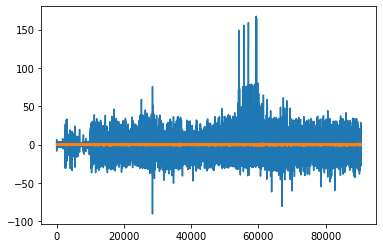

In [16]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters

f0 = ba_utils.fun(params_opt, cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, params_opt, jac_sparsity=A, verbose=1, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, cam_params, pts_3d)

Error before BA (mean / median): 13.68 / 12.14
Error after  BA (mean / median): 0.49 / 0.40


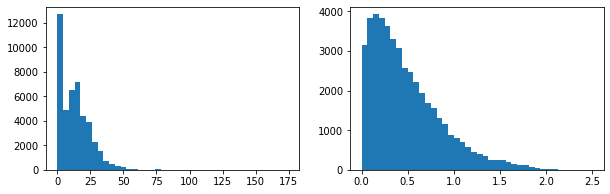

In [17]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40);
f[1].hist(ba_e, bins=40); 

In [18]:
P_crop_ba[0]



array([[ 5.42312648e-01,  3.44331697e-01, -1.51260007e-01,  1.92865370e+06],
       [ 6.34584806e-02, -3.48813812e-01, -5.60305521e-01, -1.58090522e+05],
       [-6.77688548e-08,  1.30454594e-07, -2.75472711e-09,  1.00000000e+00]])

In [19]:
P_crop[0]

array([[ 5.42312320e-01,  3.44331943e-01, -1.51260623e-01,  1.92865370e+06],
       [ 6.34582500e-02, -3.48814080e-01, -5.60305380e-01, -1.58090522e+05],
       [-6.77689360e-08,  1.30454552e-07, -2.75474510e-09,  1.00000000e+00]])

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

 ----> Real 2D loc in im 0  (sol) =  [ 94.1197052  403.69168091]
 ----> Proj 2D loc in im 0  before BA =  [ 90.2974233  404.50464712]
 ----> Proj 2D loc in im 0  after  BA =  [ 94.29802544 404.01853272]
              Reprojection error beofre BA: 4.635248111837612
              Reprojection error after  BA: 0.5051720563457707
 ----> Real 2D loc in im 3  (sol) =  [109.69831848 411.4694519 ]
 ----> Proj 2D loc in im 3  before BA =  [100.71284151 407.30314809]
 ----> Proj 2D loc in im 3  after  BA =  [109.78112223 411.61164314]
              Reprojection error beofre BA: 13.151780788309978
              Reprojection error after  BA: 0.22499498794788053
 ----> Real 2D loc in im 12  (sol) =  [120.4063797  446.14126587]
 ----> Proj 2D loc in im 12  before BA =  [125.80921611 450.90695197]
 ----> Proj 2D loc in im 12  after  BA =  [120.15609116 445.70702367]
              Reprojection error beofre BA: 10.168522507716574
              Reprojection error after  BA: 0.6845307442791153

ECEF coor

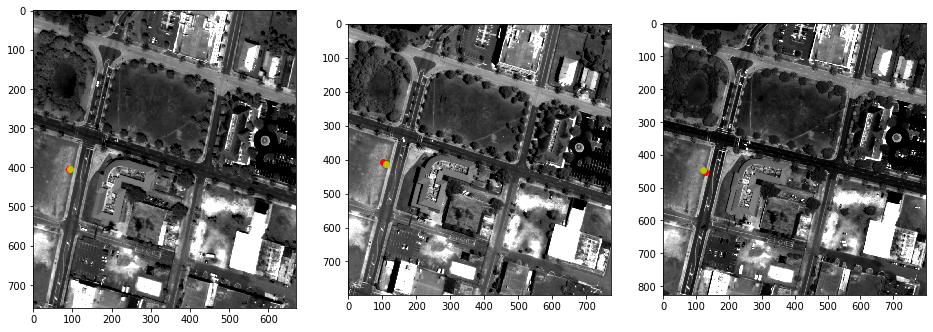

In [20]:
n_pts = newC.shape[1]
#p_ind = pts_ind[np.argmax(ba_e)] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(newC[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = newC[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'], cmap="gray")
    f[cont].plot(*p_2d_gt, "go")
    f[cont].plot(*p_2d_proj, "ro")
    f[cont].plot(*p_2d_proj_ba, "yo")
    
print('\nECEF coordinates of the 3D point:', pts_3d_ba[p_ind])
lat, lon, h = ba_utils.ecef_to_latlon_custom(x=pts_3d_ba[p_ind,0], y=pts_3d_ba[p_ind,1], z=pts_3d_ba[p_ind,2])
print('lat, lon: [{:.3f}, {:.3f}], alt: {:.3f}'.format(lat, lon, h))

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

image 0, mean abs reproj error before BA: 14.8235
image 0, mean abs reproj error after  BA: 0.5600


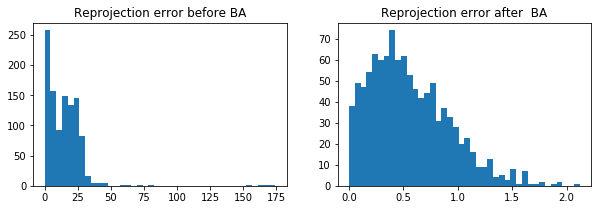

In [21]:
# set the index of the image to analyse
im_idx = pairs_to_match[0][0]

# pick all points visible in the selected image
pts_gt = newC[(im_idx*2):(im_idx*2+2),~np.isnan(newC[im_idx*2,:])].T

pts_3d_before = pts_3d[~np.isnan(newC[im_idx*2,:]),:]
pts_3d_after = pts_3d_ba[~np.isnan(newC[im_idx*2,:]),:]

# reprojections before bundle adjustment
proj = P_crop[im_idx] @ np.hstack((pts_3d_before, np.ones((pts_3d_before.shape[0],1)))).T
pts_reproj_before = (proj[:2,:]/proj[-1,:]).T
#pts_reproj_before = pts_reproj_before[::-1]

# reprojections after bundle adjustment
proj = P_crop_ba[im_idx] @ np.hstack((pts_3d_after, np.ones((pts_3d_after.shape[0],1)))).T
pts_reproj_after = (proj[:2,:]/proj[-1,:]).T

err_before = np.sum(abs(pts_reproj_before - pts_gt), axis=1)
err_after = np.sum(abs(pts_reproj_after - pts_gt), axis=1)

print('image {}, mean abs reproj error before BA: {:.4f}'.format(im_idx, np.mean(err_before)))
print('image {}, mean abs reproj error after  BA: {:.4f}'.format(im_idx, np.mean(err_after)))

# reprojection error histograms for the selected image
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Reprojection error before BA')
ax2.title.set_text('Reprojection error after  BA')
ax1.hist(err_before, bins=40); 
ax2.hist(err_after, bins=40);

plt.show()

Simple visualization. Green crosses represent the detected feature tracks, and red vectors are the distance to the reprojected point locations. 

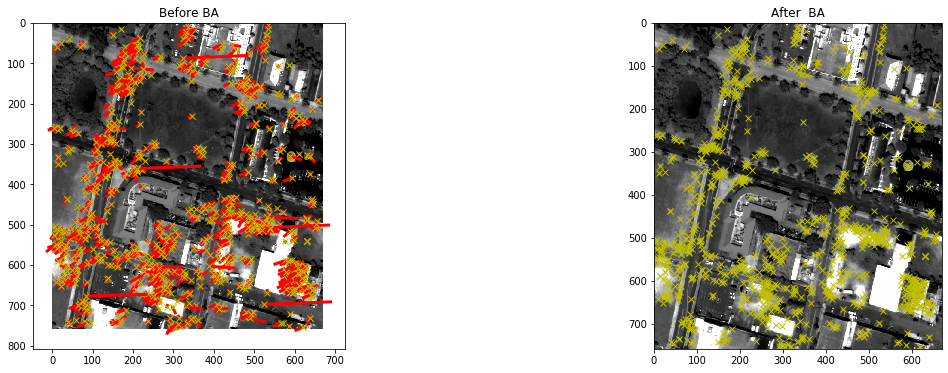

In [22]:
# warning: this is slow...

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Before BA')
ax2.title.set_text('After  BA')
ax1.imshow((mycrops[im_idx]['crop']), cmap="gray")
ax2.imshow((mycrops[im_idx]['crop']), cmap="gray")
for k in range(min(1000,pts_gt.shape[0])):
    # before bundle adjustment
    ax1.plot([pts_gt[k,0], pts_reproj_before[k,0] ], [pts_gt[k,1], pts_reproj_before[k,1] ], 'r-', lw=3)
    ax1.plot(*pts_gt[k], 'yx')
    # after bundle adjustment
    #ax2.plot([pts_gt[k,0], pts_reproj_after[k,0] ], [pts_gt[k,1], pts_reproj_after[k,1]], 'r-', lw=3)
    ax2.plot(*pts_gt[k], 'yx')
plt.show()


### Check the distance between the projection rays of two cameras

This gives an idea of the error in the traingulation of points before and after Bundle Adjustment.

Checking the distance between projection rays...
...done!



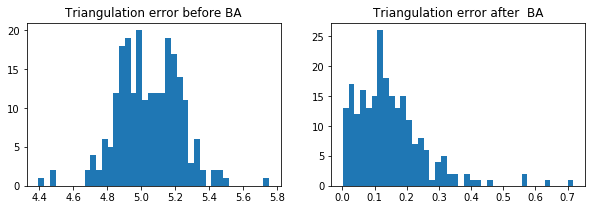

In [23]:
from PIL import Image

if CHECK_TRIANGULATION_DISTANCE and cam_model == 'Perspective':

    print('Checking the distance between projection rays...')

    im1, im2 = pairs_to_match[0] 

    # get SIFT keypoints visible in both images
    visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:]))
    pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]
    tr_err, tr_err_ba = [],[]
    pts_3d_sift, pts_3d_sift_ba = np.zeros((pts1.shape[1], 3)), np.zeros((pts1.shape[1], 3))

    triangulate_err_hist = True 
    triangulate_err_dsm  = False

    # triangulate and compute triangulation error (i.e. distance between projection rays)
    for n in range(pts1.shape[1]):
        pt1, pt2 = pts1[:,n].ravel(), pts2[:,n].ravel()
        # before bundle adjustment
        pts_3d_sift[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[im1], P_crop[im2])
        tr_err.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop[im1], P_crop[im2]))
        # after bundle adjustment
        pts_3d_sift_ba[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2])
        tr_err_ba.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2]))
        
    if triangulate_err_hist:
        
        fig = plt.figure(figsize=(10,3))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.title.set_text('Triangulation error before BA')
        ax2.title.set_text('Triangulation error after  BA')
        ax1.hist(tr_err, bins=40); 
        ax2.hist(tr_err_ba, bins=40);
        
    # project dsm of the cloud but instead of projecting the height, project the triangulation error
    if triangulate_err_dsm:
        # before bundle adjustment
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, tr_err)).T
        _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan)
        im.save(input_dir+'/triangulate_{}_{}.tif'.format(im1,im2))
        # after bundle adjustment
        x , y, z = pts_3d_sift_ba[:,0], pts_3d_sift_ba[:,1], pts_3d_sift_ba[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, tr_err_ba)).T
        _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan)
        im.save(input_dir+'/triangulate_{}_{}_ba.tif'.format(im1,im2))

    print('...done!\n')

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [24]:
if SAVE_SIFT_CLOUDS:

    print('Writing point clouds of SIFT keypoints...')

    if not os.path.isdir(input_dir+'/sift_clouds_before'):
        os.mkdir(input_dir+'/sift_clouds_before')
    if not os.path.isdir(input_dir+'/sift_clouds_after'):
        os.mkdir(input_dir+'/sift_clouds_after')

    for [im1,im2] in pairs_to_match:

        # get SIFT keypoints visible in both images
        visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:])) 
        pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]

        # triangulation of SIFT keypoints before bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop[im1], P_crop[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_before/{:02}_{:02}.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))

        # triangulation of SIFT keypoints after bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop_ba[im1], P_crop_ba[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_after/{:02}_{:02}_ba.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))

    print('...done!\n')

Writing point clouds of SIFT keypoints...
...done!



### Compute point clouds for all pairs

In [74]:
if ALL_PIPELINE:
    
    import warnings
    warnings.filterwarnings('ignore')
    
    list_of_pairs = ba_utils.get_predefined_pairs('pairs/'+site+'_'+order+'.txt', site, order, myimages)
    
    if not os.path.isdir(input_dir+'/clouds'):
        os.mkdir(input_dir+'/clouds')

    def create_cloud(pair):
        i, j = pair
        cloud =  ba_utils.cloud_from_pair(i, j, P_crop_ba[i], P_crop_ba[j], cam_model, myimages, mycrops, aoi)
        x , y, z = cloud[:,0], cloud[:,1], cloud[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(i,j), xyz)
    
    print('\nComputing point clouds from stereo pairs...')
    for iter_cont, pair in enumerate(list_of_pairs):
        create_cloud(pair)
        print('{} / {} done'.format(iter_cont+1, len(list_of_pairs)))
    print('\nDone!\n')


Computing point clouds from stereo pairs...
t=3.9579 done building CV
t=8.8673 done sgmfilter
t=9.5604 done aggregation and WTA refinement
t=4.1608 done building CV
t=8.8064 done sgmfilter
t=9.1541 done aggregation and WTA refinement
1 / 50 done
t=4.1282 done building CV
t=8.8141 done sgmfilter
t=9.1896 done aggregation and WTA refinement
t=4.4845 done building CV
t=9.2262 done sgmfilter
t=9.5898 done aggregation and WTA refinement
2 / 50 done
t=3.4322 done building CV
t=7.4004 done sgmfilter
t=7.6999 done aggregation and WTA refinement
t=3.5345 done building CV
t=7.8298 done sgmfilter
t=8.1513 done aggregation and WTA refinement
3 / 50 done
t=3.9069 done building CV
t=8.4416 done sgmfilter
t=8.8098 done aggregation and WTA refinement
t=4.6357 done building CV
t=9.4086 done sgmfilter
t=9.7428 done aggregation and WTA refinement
4 / 50 done
t=4.7561 done building CV
t=10.0387 done sgmfilter
t=10.4322 done aggregation and WTA refinement
t=5.2671 done building CV
t=10.7579 done sgmfilter

t=10.6643 done sgmfilter
t=11.0553 done aggregation and WTA refinement
40 / 50 done
t=3.9199 done building CV
t=8.1545 done sgmfilter
t=8.5303 done aggregation and WTA refinement
t=4.5704 done building CV
t=9.1554 done sgmfilter
t=9.4504 done aggregation and WTA refinement
41 / 50 done
t=2.8509 done building CV
t=6.7419 done sgmfilter
t=6.9871 done aggregation and WTA refinement
t=3.4860 done building CV
t=7.1581 done sgmfilter
t=7.4250 done aggregation and WTA refinement
42 / 50 done
t=5.8970 done building CV
t=12.0760 done sgmfilter
t=12.5945 done aggregation and WTA refinement
t=6.1850 done building CV
t=12.6728 done sgmfilter
t=13.1543 done aggregation and WTA refinement
43 / 50 done
t=4.7435 done building CV
t=9.9893 done sgmfilter
t=10.3792 done aggregation and WTA refinement
t=4.5158 done building CV
t=9.3901 done sgmfilter
t=9.7599 done aggregation and WTA refinement
44 / 50 done
t=6.5154 done building CV
t=14.1313 done sgmfilter
t=14.6838 done aggregation and WTA refinement
t=

### Postprocess output DSMs

In [75]:
if ALL_PIPELINE:
    
    from PIL import Image
    import re
    import subprocess

    if not os.path.isdir(input_dir+'/dsm'):
        os.mkdir(input_dir+'/dsm')
    if not os.path.isdir(input_dir+'/cdsm'):
        os.mkdir(input_dir+'/cdsm')
    if not os.path.isdir(input_dir+'/output'):
        os.mkdir(input_dir+'/output')

    # use the aoi to set the limits of the grid where the point clouds will be projected to DSMs
    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    px_size = 0.300000011920929 # to set the DSMs resolution

    # project all point colouds to DSMs
    print('Creating DSMs...')
    ply_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/clouds')][0]
    for iter_cont, filename in enumerate(ply_files):
        xyz = ba_utils.read_point_cloud_ply(input_dir+'/clouds/'+filename)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)
        im = Image.fromarray(dem_nan)
        im.save(input_dir+'/dsm/dsm_{}.tif'.format(os.path.splitext(filename[12:])[0]))
        print('\r{} / {} done'.format(iter_cont+1, len(ply_files)), end = '\r')
    print('\nDone!\n')

    # post-process DSMs
    print('Post-processing DSMs...')
    dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/dsm')][0]
    
    for iter_cont, filename in enumerate(dsm_files):
        dsm = input_dir+'/dsm/'+filename # original dsm

        # small hole interpolation by closing
        cdsm = input_dir+'/cdsm/c'+filename  # dsm after closing
        
        os.system('bin/morsi square closing {0} | bin/plambda {0} - "x isfinite x y isfinite y nan if if" -o {1}'.format(dsm, cdsm))

        # no interpolation is used here
        # since interpolated dsms are only used in pipelineA to comptue the max ncc transfromation
        print('\r{} / {} done'.format(iter_cont+1, len(dsm_files)), end = '\r')
    print('\nDone!\n')

Creating DSMs...
50 / 50 done
Done!

Post-processing DSMs...
50 / 50 done
Done!



### Fuse output DSMs

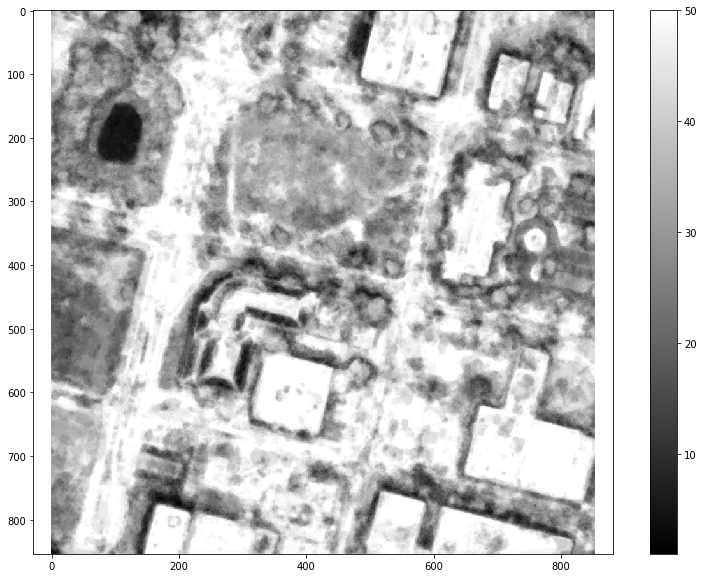

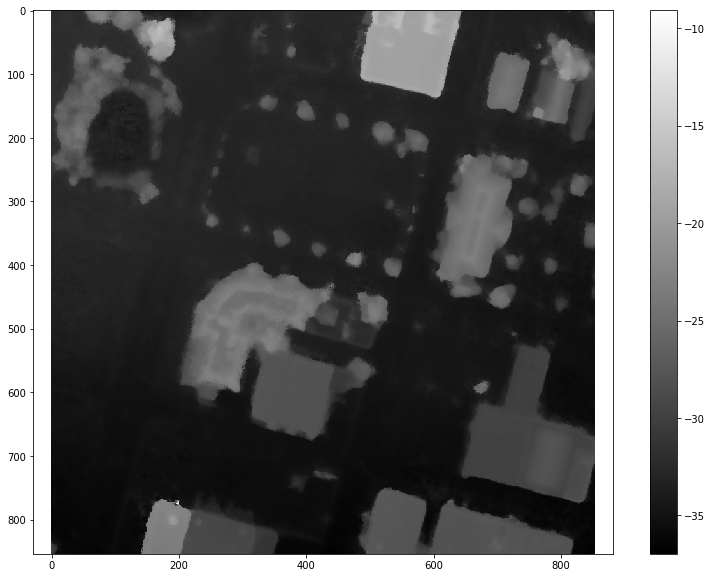

In [76]:
if ALL_PIPELINE:

    from PIL import Image
    import re
    import subprocess

    # stack the N output DSMs in a WxHxN grid
    rcdsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/cdsm')][0]
    olist = [input_dir+'/cdsm/'+filename for filename in rcdsm_files]
    u=[]
    for ofile in olist:
        u.append(np.array(Image.open(ofile)))
    stacked_rcdsm = np.dstack(u)

    # pointwise median to fuse all DSMs
    fusion_result = np.nanmedian(stacked_rcdsm, axis=2)

    # visualize the number of samples per pixel
    nan_idx = np.isnan(stacked_rcdsm)
    obs_per_px = np.sum((~nan_idx).astype(int), axis=2).astype(float)

    vistools.display_imshow(obs_per_px)
    vistools.display_imshow(fusion_result)
    im = Image.fromarray(fusion_result)
    im.save(input_dir+'/output/fused_dsm.tif')

### Prepare GT DSM

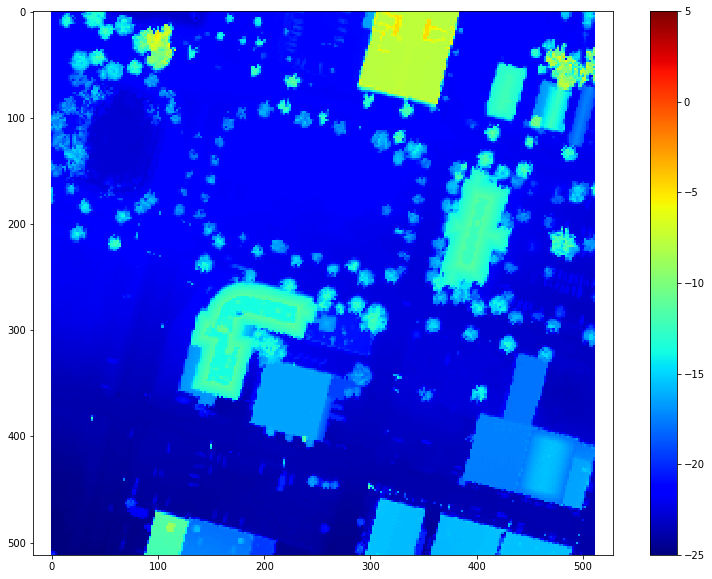

In [77]:
# prepare GT dem to obtain performance score

if ALL_PIPELINE:

    from PIL import Image

    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    px_size = 0.300000011920929
    
    # read the ground truth geotiff 
    gt_dsm = np.array(Image.open('gt/'+site+'_gt.tif'))

    if site == 'IARPA':
        # write the necessary data from gdalinfo (northing (y) needs to be expressed in negative coordinates)
        epsg, x, y, px_size = 32721, 354449.320, 6182457.920 - 10000000, 0.300000011920929
        # attention: the top-left corner from the gt tiff and the one from the aoi are not exactly coincident
        # save the gt geotiff but this time with northing in negative coordinates
        ba_utils.save_geotiff(input_dir+'/gt_dsm2.tif', gt_dsm.astype(np.float64), epsg, x, y, r=px_size)
    else:
        os.system('cp gt/'+site+'_gt.tif '+input_dir+'/gt_dsm2.tif')
    
    # elevate the geotiff we just wrote and write the point cloud in a ply file
    os.system('bin/elevate '+input_dir+'/gt_dsm2.tif > '+input_dir+'/gt_cloud.txt')
    os.remove(input_dir+'/gt_dsm2.tif')
    xyz = ba_utils.read_point_cloud_txt(input_dir+'/gt_cloud.txt')
    os.remove(input_dir+'/gt_cloud.txt')
    ba_utils.write_point_cloud_ply(input_dir+'/gt_cloud.ply', xyz)

    # project the recently created point cloud into the aoi and create a dem
    xyz = ba_utils.read_point_cloud_ply(input_dir+'/gt_cloud.ply')
    dem_3,dem_nan,dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)

    # save the dem as the new ready-to-be-used gt
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/gt_dsm_nan.tif')

    # filter those values where we do not have gt available
    rows_with_gt = ~np.all(np.isnan(dem_nan), axis=1)
    cols_with_gt = ~np.all(np.isnan(dem_nan), axis=0)
    dem_3 = dem_3[rows_with_gt, :]
    dem_3 = dem_3[:, cols_with_gt]
    im = Image.fromarray(dem_3)
    im.save(input_dir+'/gt_dsm_registered.tif')

    if site == 'IARPA':
        vistools.display_imshow(dem_3, cmap='jet', range=(10,50))
    else:
        vistools.display_imshow(dem_3, cmap='jet', range=(5,-25))

### Register solution and ground-truth DSMs

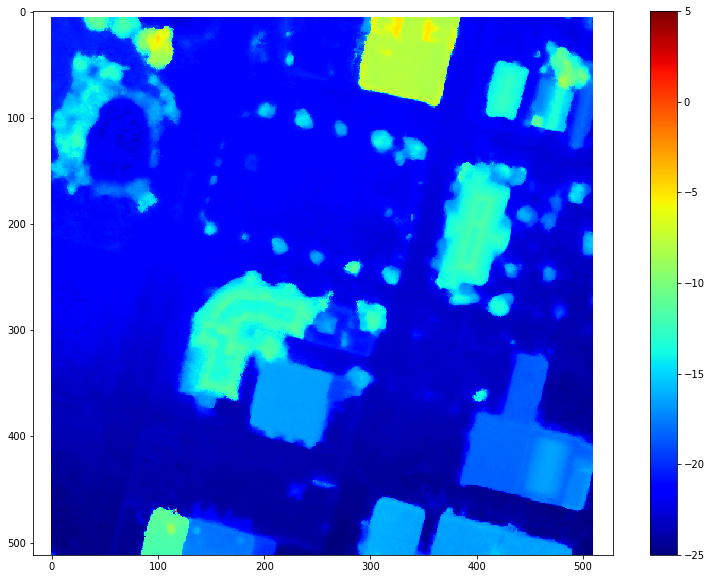

In [78]:
if ALL_PIPELINE:
    
    # prepare SOL dem to obtain performance score

    # read fused and gt dem
    out_dsm = np.array(Image.open(input_dir+'/output/fused_dsm.tif'))
    gt_dsm  = np.array(Image.open(input_dir+'/gt_dsm_nan.tif'))

    # filter those values where we do not have gt available
    rows_with_gt = ~np.all(np.isnan(gt_dsm), axis=1)
    cols_with_gt = ~np.all(np.isnan(gt_dsm), axis=0)
    out_dsm2 = out_dsm[rows_with_gt, :]
    out_dsm2 = out_dsm2[:, cols_with_gt]
    im = Image.fromarray(out_dsm2)
    im.save(input_dir+'/output/fused_dsm2.tif')

    out_dsm = input_dir+'/output/fused_dsm2.tif'
    gt_dsm  = input_dir+'/gt_dsm_registered.tif'

    # compute horizontal registration on the interpolated DSMs
    trans = input_dir+'/output/t_sol.txt'
    os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(gt_dsm, out_dsm, trans))
    dx, dy = np.loadtxt(trans)[:2]

    # compute vertical registration on the original DSMs
    os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(gt_dsm, out_dsm, dx, dy, trans))

    # apply the registration
    os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(out_dsm, trans, input_dir+'/output/sol_dsm_registered.tif'))

    # copy geotiff properties from the gt dsm to the sol dsm
    #os.system('python gdalcopyproj.py {} {}'.format(gt_dsm, input_dir+'/sol_dsm.tif'))

    os.remove(input_dir+'/output/fused_dsm2.tif')
    sol_dsm = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))
    
    if site == 'IARPA':
        vistools.display_imshow(sol_dsm, cmap='jet', range=(10,50))
    else:
        vistools.display_imshow(sol_dsm, cmap='jet', range=(5,-25))

### Evaluation

score: 79.52423095703125
nan: 1.55792236328125
mean_e: 0.9053648
median_e: 0.39060974
std_e: 1.529582


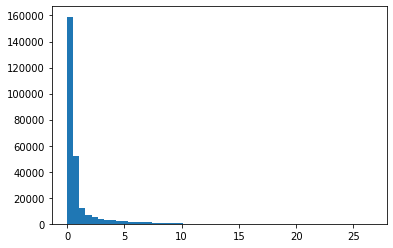

In [79]:
if ALL_PIPELINE:
    
    # compute score
    from PIL import Image

    #input_dir = 'ba_experiments/50pairs_iarpa'

    dem_gt = np.array(Image.open(input_dir+'/gt_dsm_registered.tif'))
    dem_sol = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))

    # compute mse and completness (i.e. % of px with error lower than 1 m)
    # first remove possible nans from the solution
    idx = ~np.isnan(dem_sol)
    dem_gt2, dem_sol2 = dem_gt[idx], dem_sol[idx]
    #total_px = dem_gt2.shape[0]
    nan_values = 100 - ((dem_gt2.shape[0]/ (dem_gt.shape[0] * dem_gt.shape[1]) ) * 100)
    mean_e = np.mean((abs(dem_gt2 - dem_sol2)))
    median_e = np.median(abs(dem_gt2 - dem_sol2))
    std_e = np.std(abs(dem_gt2 - dem_sol2))
    total_px = dem_gt.shape[0] * dem_gt.shape[1]
    completness = sum( (abs(dem_gt2 - dem_sol2) < 1.0).astype(int) ) / total_px * 100

    plt.hist(abs(dem_gt2 - dem_sol2), bins=50) 

    print('score:', completness)
    print('nan:', nan_values)
    print('mean_e:', mean_e)
    print('median_e:', median_e)
    print('std_e:', std_e)

### Get sift order

In [80]:
pickle_in = open(input_dir+'/features2.pickle','rb')
C = pickle.load(pickle_in)
print('Correspondence matrix loaded!')

n_cam = int(newC.shape[0]/2)
n_correspondences_filt, tmp_pairs = [], []
for im1 in range(n_cam):
    for im2 in range(im1+1,n_cam):
        obs_im1 = 1*np.invert(np.isnan(newC[2*im1,:]))
        obs_im2 = 1*np.invert(np.isnan(newC[2*im2,:]))
        n_matches = np.sum(np.sum(np.vstack((obs_im1, obs_im2)), axis=0) == 2)
        n_correspondences_filt.append(n_matches)
        tmp_pairs.append((im1,im2))
        
n_correspondences_filt = np.array(n_correspondences_filt)

sorted_indices = np.flip(np.argsort(n_correspondences_filt))

#F = open(input_dir+'/sift_order.txt','w')
#for index in sorted_indices:
#    F.write('{} {}\n'.format(tmp_pairs[index][0]+1, tmp_pairs[index][1]+1))
#F.close()

Correspondence matrix loaded!
